In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
%matplotlib inline

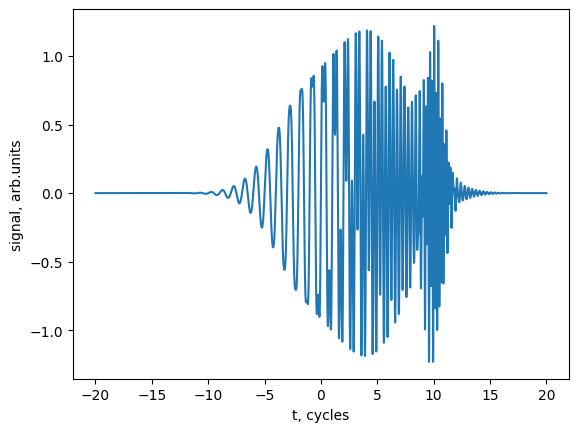

In [3]:
# generate the signal
pi = np.pi
t=np.linspace(-20*2*pi, 20*2*pi, 3**9+6)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*pi)**2/2/5**2)

plt.plot(t/2/pi,y)

plt.xlabel('t, cycles')
plt.ylabel('signal, arb.units');

In [4]:
# windowed Fourier transform (Gabor transform, spectrogram)

def pic(data,dims):
    fig, ax = plt.subplots(figsize=(14, 11))
    image = ax.imshow(data, aspect='auto', origin='lower',extent=dims)
    fig.colorbar(image, orientation='vertical')
    ax.set_ylim(0, 7)
    ax.set_xlabel('window position')
    ax.set_ylabel('frequency')
    
# x_axis is window position
# y_axis is frequency
# color axis represents the power spectrum

In [5]:
%%writefile parallel_specv2.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


pi = np.pi
t=np.linspace(-20*2*pi, 20*2*pi, 3**9+6)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*pi)**2/2/5**2)

def get_specgram(time, signal, size, rank, width = 1.5, osc = 20, nwindowsteps = 1000):
    
    step = nwindowsteps//size
    position = np.linspace(-osc,osc,nwindowsteps)
    specgram = np.empty((len(time),step))
    
    l = rank*step
    r = (rank+1)*step
    
    for ind, val in enumerate(position[l:r]):
        window_width = width*2*np.pi
        window_position = val*2*np.pi
        window_function = np.exp(-(time-window_position)**2/(2*window_width**2))
        y_window = signal*window_function
        
        
        w=np.fft.fftfreq(len(signal), d=(time[1]-time[0])/2/pi)
        dims =[min(time)/(2*np.pi), max(time)/(2*np.pi), w[0], 2*w[int(len(time)/2)-1]] 
        specgram[:,ind] = abs(np.fft.fft(y_window))
    
    return specgram, dims, np.shape(specgram)[0]

spec, dims, height = get_specgram(t, y, size, rank)
print(f"{rank} process is done ")
data = comm.gather((spec,dims), root=0)


if rank == 0:
    dims = data[0][1]
    spec = np.empty((height,0))
    for i in range(len(data)):
        spec = np.concatenate((spec,data[i][0]),axis = 1) 
    print(f"Number of processes: {size}")
    
    np.savetxt("dims.csv", dims, delimiter = ",")
    np.savetxt("spec.csv", spec, delimiter = " ")
	


Overwriting parallel_specv2.py


In [6]:
!mpiexec -np 5 python parallel_specv2.py

1 process is done 
2 process is done 
3 process is done 
4 process is done 
0 process is done 
Number of processes: 5


In [7]:
spec = np.loadtxt("spec.csv",delimiter = ' ')
dims = np.loadtxt("dims.csv", delimiter = ',')


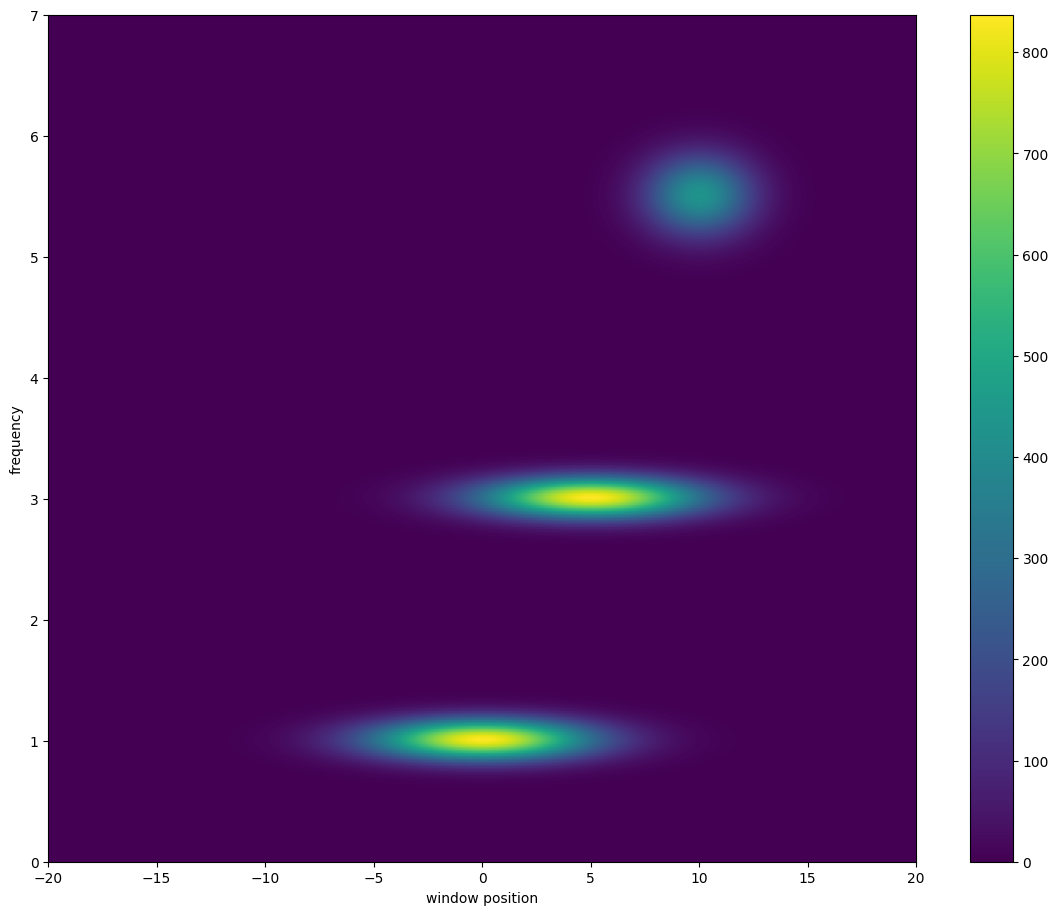

In [8]:
pic(spec,dims)

In [76]:
n = np.arange(1,9)
results = list()

for i in n:
    a = %timeit -o -r 2 !mpiexec -np {i} python parallel_specv2.py
    results.append(a.best)

0 process is done 
Number of processes: 1
0 process is done 
Number of processes: 1
0 process is done 
Number of processes: 1
11.9 s ± 168 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1 process is done 
0 process is done 
Number of processes: 2
1 process is done 
0 process is done 
Number of processes: 2
1 process is done 
0 process is done 
Number of processes: 2
9.52 s ± 1.13 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
1 process is done 
2 process is done 
0 process is done 
Number of processes: 3
1 process is done 
2 process is done 
0 process is done 
Number of processes: 3
1 process is done 
2 process is done 
0 process is done 
Number of processes: 3
7.62 s ± 202 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
1 process is done 
2 process is done 
3 process is done 
0 process is done 
Number of processes: 4
1 process is done 
2 process is done 
3 process is done 
0 process is done 
Number of processes: 4
1 process is done 
2 process is done 
3 process is d

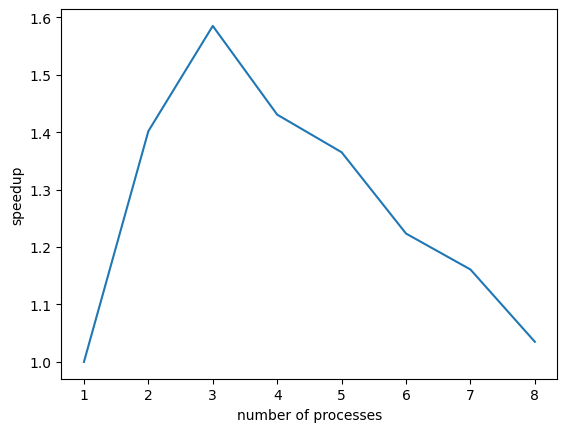

In [77]:
res = list(map(lambda x: results[0]/x, results))
plt.plot(n,res)
plt.xlabel("number of processes")
plt.ylabel("speedup");